[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/comp-neural-circuits/plasticity-workshop/blob/dev/rate_based.ipynb)

# Hebbian Plasticity (Rate-Based)


Welcome to the first section of the synaptic plasticity tutorial !  

Today we will learn :

+ How to define a simple, rate-based, feedforward (FF) network model. And then we will look at the activity of the input neurons.
+ How to implement the covariance-based and the correlation-based learning rule.
+ How the covariance-based learning rule is equivalent to finding the first principal component of the input activity.
+ How additive or multiplicative constraints change the learning dynamics

Please run the two cells below (i.e. Initialization and Utility functions) to initialize and implement the figure setup.

## Initialization

In [2]:
!pip install numpy scipy matplotlib ipywidgets scikit-learn panel --quiet
import numpy as np
import scipy.linalg as lin
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# for the PCA
from sklearn.decomposition import PCA
plt.style.use("https://github.com/comp-neural-circuits/plasticity-workshop/raw/dev/plots_style.txt")#
#plt.style.use("plots_style.txt")

## Utility Functions

In [ ]:
def ornstein_uhlenbeck(mean,cov,dt,Ttot,dts=1E-2):
    """
    Generates a multi-dimensional Ornstein-Uhlenbeck process.

    Parameters :
    mean (1D numpy array) : desired mean
    cov  (2D numpy array)   : covariance matrix (symmetric, positive definite)
    dt   (number)     : timestep output
    Tot  (number)     : total time
    dts = 1E-3 (number) : simulation timestep

    Returns :
    times (1D numpy array)
    rates (2D numpy array)  :  rates[i,j] is the rate of unit i at time times[j]
    """
    times = np.arange(0.0,Ttot,dt)
    n = len(mean)
    nTs = int(Ttot/dts)
    rates_all = np.empty((n,nTs))
    rates_all[:,0] = mean
    L = lin.cholesky(cov)
    nskip = int(dt/dts)
    assert round(dts*nskip,5) == dt , "dt must be multiple of  " + str(dts)
    for t in range(1,nTs):
        dr = dts*(mean-rates_all[:,t-1])
        dpsi = np.sqrt(2*dts)*(L.T @ rng.standard_normal(n))
        rates_all[:,t] = rates_all[:,t-1] + dr + dpsi
    # subsample 
    rates = rates_all[:,::nskip]
    return times,rates
  
def twodimensional_OU(mean1,var1,mean2,var2,corr,dt,Ttot,dts=1E-2):
    """
    Generates samples from a 2D Ornstein-Uhlenbeck process.

    Parameters :
    mean1 (real) : mean on first dimension
    var1  (real) : variance on first dimension (at dt=1. intervals)
    mean2 (real) : - 
    var2  (real) : - 
    corr  (real) : correlation coefficient 
    dt   (real)     : timestep output
    Tot  (real)     : total time
    dts = 1E-3 (real) : simulation timestep

    Returns :
    times  (1D numpy array)
    rates1 (1D numpy array)
    rates2 (1D numpy array)
    """
    assert -1<corr<1, "correlation must be in (-1,1) interval"
    var12 = corr*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    (times, rates) = ornstein_uhlenbeck(
      np.array([mean1,mean2]),
      cov_mat,
      dt,Ttot,dts)
    return times, rates #rates[0,:],rates[1,:]

def test_rate_response():
    r_input = np.array( [ [1.2, 4.44, 234.0] ,[2, 54.04, 4.03], [6.2, 2.9, 0.888]] )
    weights = np.array([0.789, -3.4, 4.0])
    
    
    res1 = rate_response(r_input,weights)
    res1_expected = np.array([ np.dot(r_input[:,0],weights), 
                               np.dot(r_input[:,1],weights),
                               np.dot(r_input[:,2],weights)])
    print("Testing rate response")
    print(f"expected: {res1_expected} \t function output {res1}") 
    if all(np.isclose(res1,res1_expected,rtol=0.001)):
        print("**** test PASSED ! ****")
    else:
        print("**** test FAILED ! ****")
    return 

def plot_r1_and_r2(correlation=0.0,mean_r1=0.0,mean_r2=0.0,var_r1=1.0,var_r2=1.0):
    times,rates = twodimensional_OU(mean_r1,var_r1,mean_r2,var_r2,correlation,0.1,60.0)
    rates1 = rates[0,:]
    rates2 = rates[1,:]
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10)) #gridspec_kw={'height_ratios': [3, 1]})
    ax1.plot(times,rates1)
    ax1.plot(times,rates2)
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("rate (Hz)")
    ax1.set_title("time traces")
    ax2.scatter(rates1,rates2,color="black")
    ax2.set_title("samples r1 Vs r2")
    ax2.set_xlabel("rate 1 (Hz)")
    ax2.set_ylabel("rate 2 (Hz)")
    ax2.axis("equal")
    return 

def analytic_correlation_based(r_means,r_cov,times,weights_start,gamma):
    """
    Computes the analytic solution for the correlation-based
    plasticity rule. Assuming the input is a multi dimensional 
    O-U process.
    
    Parameters :
    r_means (1D numpy array) : mean rate for each input neuron
    r_cov   (2D numpy array) : covariance matrix of input activity
    times   (1D numpy array) : time vector
    weights_start (1D numpy array) : initial conditions for weights
    gamma   (number) : learning coefficient
    
    Returns :
    weights (2D numpy array) : weights[i,k] is the weight from neuron i at time times[k]
    """
    Ntimes = len(times)
    N = len(r_means)
    weights = np.empty((N,Ntimes))
    M = gamma*(r_cov + np.outer(r_means,r_means)) + np.identity(N)
    for k in range(Ntimes):
        weights[:,k] = np.linalg.matrix_power(M,k) @ weights_start
    return weights

def analytic_covariance_based(r_means,r_cov,times,weights_start,gamma):
    """
    Computes the analytic solution for the covariance-based
    plasticity rule. Assuming the input is a multi dimensional 
    O-U process.
    
    Parameters :
    r_means (1D numpy array) : input means
    r_cov   (2D numpy array) : input covariance matrix
    times   (1D numpy array) : time vector
    weights_start (1D numpy array) : initial conditions for weights
    gamma   (number) : learning coefficient 
    
    Returns :
    weights (2D numpy array) : weights[i,k] is the weight from neuron i at time times[k]
    """
    Ntimes = len(times)
    N = len(r_means)
    weights = np.empty((N,Ntimes))
    M = gamma*r_cov + np.identity(N)
    for k in range(Ntimes):
        weights[:,k] = np.linalg.matrix_power(M,k) @ weights_start
    return weights



def test_weight_update_correlation():
    # numeric result
    mean_r1,var1 = 3.0,0.3
    mean_r2,var2 = 5.0, 0.2
    correlation = 0.7
    T = 100.0
    gamma = 1.0
    weights = rng.random(2) + 5.0
    times,rates_input = twodimensional_OU(mean_r1,var1,mean_r2,var2,correlation,0.2,T)
    weight_update = weight_update_correlation(rates_input,weights,gamma)
    
    # analytic result
    var12 = correlation*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    r_means = np.array([mean_r1,mean_r2])
    weights_an = analytic_correlation_based(r_means,cov_mat,np.array([0,T]),weights,gamma)[:,1]
    weight_update_an = weights_an - weights
    print(f"expected (approx): {weight_update_an} \t function output {weight_update}") 
    if all(np.isclose(weight_update,weight_update_an,rtol=0.3)):
        print("**** test PASSED ! ****")
    else:
        print("**** test FAILED ! ****")
    return
 
def test_weight_update_covariance():
    # numeric result
    mean_r1,var1 = 3.0,0.3
    mean_r2,var2 = 5.0, 0.2
    correlation = 0.7
    T = 100.0
    gamma = 1.0
    weights = rng.random(2) + 5.0
    times,rates_input = twodimensional_OU(mean_r1,var1,mean_r2,var2,correlation,0.2,T)
    weight_update = weight_update_covariance(rates_input,weights,gamma)
    
    # analytic result
    var12 = correlation*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    r_means = np.array([mean_r1,mean_r2])
    weights_an = analytic_covariance_based(r_means,cov_mat,np.array([0,T]),weights,gamma)[:,1]
    weight_update_an = weights_an - weights
    print(f"expected (approx): {weight_update_an} \t function output {weight_update}") 
    if all(np.isclose(weight_update,weight_update_an,rtol=0.3)):
        print("**** test PASSED ! ****")
    else:
        print("**** test FAILED ! ****")

        
def weight_evolution_correlation(mean_r1,var1,mean_r2,var2,correlation,
                                 weights_start,Tstep=60.0,Nsteps=30,gammahat=1E-3,dtsample=0.2):
    weight_ret = np.empty(Nsteps)
    times_ret = np.arange(0.0,Tstep*Nsteps,Tstep)
    gamma = gammahat*Tstep
    weights_temp = np.copy(weights_start)
    for k in range(Nsteps):
        # save weight
        weight_ret[k]=weights_temp[0]
        # simulate input neuron activity for Tstep duration
        _times,_rates_input = twodimensional_OU(mean_r1,var1,mean_r2,var2,correlation,dtsample,Tstep)
        # compute weight update value, and update the weights
        _weight_updates = weight_update_correlation(_rates_input,weights_temp,gamma)
        weights_temp += _weight_updates
    
    # analytic solution
    var12 = correlation*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    r_means = np.array([mean_r1,mean_r2])
    weights_an = analytic_correlation_based(r_means,cov_mat,times_ret,weights_start,gamma)
        
    return times_ret,weight_ret,weights_an[0,:]

def weight_evolution_covariance(mean_r1,var1,mean_r2,var2,correlation,
                                weights_start,Tstep=60.0,Nsteps=30,gammahat=1E-3,dtsample=0.2):
    weight_ret = np.empty(Nsteps)
    times_ret = np.arange(0.0,Tstep*Nsteps,Tstep)
    gamma = gammahat*Tstep
    weights_temp = np.copy(weights_start)
    for k in range(Nsteps):
        weight_ret[k]=weights_temp[0]
        _times,_rates_input = twodimensional_OU(mean_r1,var1,mean_r2,var2,correlation,dtsample,Tstep)
        weight_updates = weight_update_covariance(_rates_input,weights_temp,gamma)
        weights_temp += weight_updates
    
    # analytic solution
    var12 = correlation*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    r_means = np.array([mean_r1,mean_r2])
    weights_an = analytic_covariance_based(r_means,cov_mat,times_ret,weights_start,gamma)
        
    return times_ret,weight_ret,weights_an[0,:]

def weight_evo_all(mean_r1,var1,mean_r2,var2,correlation,):
    # start with small initial weights
    weights_start = np.array([1E-2,1E-2])
    
    # computes values for corelation-based rule
    times,wcorr,wcorran = weight_evolution_correlation(mean_r1,var1,mean_r2,\
                                                       var2,correlation,weights_start)
    # computes values for covariance-based rule
    _,wcov,wcovan = weight_evolution_covariance(mean_r1,var1,mean_r2,\
                                                       var2,correlation,weights_start)
    # plotting
    times += times[1]-times[0] # time starts from value >0 , so I can plot in log-log scale
    fig,ax = plt.subplots()
    linecorr, = ax.plot(times,wcorr,color="xkcd:ocean blue",label="correlation-based")
    # plt.plot(times,wcorran,'--',color="xkcd:ocean blue",alpha=0.8)
    
    linecov, = ax.plot(times,wcov,color="xkcd:blood red",label="covariance-based")
    # plt.plot(times,wcovan,'--',color="xkcd:blood red",alpha=0.8)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('synaptic weight')
    ax.legend(handles=[linecorr,linecov])
    return 

#### PCA PART ###

def first_principal_component(x):
    """
    Computes the first principal component from x
    
    Parameters:
    x (2D numpy array) :  x[k,i] is the value of the i component of x at time t[k]
    
    Returns :
    pca1 (1D numpy array) : vector of norm 1 that captures the direction of maximum variability
    """
    pca = PCA(n_components=1)
    pca.fit(x)
    return pca.components_[0,:]


def plot_r1_and_r2_with_PCA(mean_r1=0.0,mean_r2=0.0,var_r1=1.0,var_r2=1.0,correlation=0.6,):
    times,rates_input = twodimensional_OU(mean_r1,var_r1,mean_r2,var_r2,correlation,0.1,60.0)
    rates1 = rates_input[0,:]
    rates2 = rates_input[1,:]
    pcavec = first_principal_component(rates_input.T)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10)) #gridspec_kw={'height_ratios': [3, 1]})
    ax1.plot(times,rates1)
    ax1.plot(times,rates2)
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("rate (Hz)")
    ax1.set_title("time traces")
    
    ax2.scatter(rates1,rates2,color="black")
    ax2.set_title("samples r1 Vs r2")
    ax2.set_xlabel("rate 1 (Hz)")
    ax2.set_ylabel("rate 2 (Hz)")
    ax2.axis("equal")
    xmin,xmax = ax2.get_xlim()
    ymin,ymax = ax2.get_ylim()
    xpca_plot = np.array([-pcavec[0]*100,pcavec[0]*100])+mean_r1
    ypca_plot = np.array([-pcavec[1]*100,pcavec[1]*100])+mean_r2
    ax2.plot(xpca_plot,ypca_plot,"--",color="red")
    ax2.set_xlim((xmin,xmax))
    ax2.set_ylim((ymin,ymax))
    return

def plot_covrule_and_PCA(mean_r1=0.0,mean_r2=0.0,var_r1=1.0,var_r2=1.0,correlation=0.6):
    gammahat=1E-3
    Tstep=100.
    Nsteps=20
    dtsample=1.0
    # simulate activity once
    # compute first pricincipal component
    times,rates_input = twodimensional_OU(mean_r1,var_r1,mean_r2,var_r2,correlation,0.2,100.0)
    rates1 = rates_input[0,:]
    rates2 = rates_input[1,:]
    pcavec = first_principal_component(rates_input.T)
    
    # now, apply covariance rule with repeated iterations
    weights_start = np.array([1E-1,1E-1])
    gamma = gammahat*Tstep
    weights_end = np.copy(weights_start)
    for k in range(Nsteps):
        _times,_rates_input = twodimensional_OU(mean_r1,var_r1,mean_r2,var_r2,correlation,dtsample,Tstep)
        _weight_updates = weight_update_covariance(_rates_input,weights_end,gamma)
        weights_end += _weight_updates
    
    # normalize the weights 
    weights_end = weights_end / lin.norm(weights_end)
    
    # do the plot
    fig,ax= plt.subplots() 
    
    ax.scatter(rates1,rates2,color="black")
    ax.set_xlabel("rate 1 (Hz)")
    ax.set_ylabel("rate 2 (Hz)")
    ax.axis("equal")
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xpca_plot = np.array([-pcavec[0]*100,pcavec[0]*100])+mean_r1
    ypca_plot = np.array([-pcavec[1]*100,pcavec[1]*100])+mean_r2
    linepca,=ax.plot(xpca_plot,ypca_plot,"--",color="red",label="1st principal component ")
    
    xw_plot = np.array([-weights_end[0]*100,weights_end[0]*100])+mean_r1
    yw_plot = np.array([-weights_end[1]*100,weights_end[1]*100])+mean_r2
    lineweights,=ax.plot(xw_plot,yw_plot,"--",color="blue",label="weights after learning")
    
    ax.set_xlim((xmin,xmax))
    ax.set_ylim((ymin,ymax))
    
    ax.legend(handles=[linepca,lineweights])
    return


def test_weight_update_bounded():
    v1,v2,c,gamma,w1,w2 = 2.,1.23,0.6,1E-2,23.,7.8
    v12 = c*np.sqrt(v1*v2)
    cov_mat = np.array([[v1,v12],[v12,v2]])
    weights = np.array([w1,w2])
    res1 = weight_update_bounded_subtractive(cov_mat,weights,gamma)
    res1_expected = np.array([  0.11050919, -0.11050919 ])
    print("Testing subtractive normalization")
    print(f"expected: {res1_expected} \t function output {res1}") 
    if all(np.isclose(res1,res1_expected,rtol=0.001)):
        print("**** test PASSED ! ****")
    else:
        print("**** test FAILED ! ****")
    print("\nTesting divisive normalization")
    res2 = weight_update_bounded_divisive(cov_mat,weights,gamma)
    res2_expected = np.array([ -0.09819161,  0.09819161  ])
    print(f"expected: {res2_expected} \t function output {res2}") 
    if all(np.isclose(res2,res2_expected,rtol=0.001)):
        print("**** test PASSED ! ****")
    else:
        print("**** test FAILED ! ****")
    return

def train_weights_vector_field_direction(
                          var1,var2,correlation,
                          weights,gamma,
                          wmin = 0.0, wmax = 1.0,
                          do_subtractive=True):
    """
    Computes the vector field of the 2D versions of 
    weigth_update_bounded_subtractive or weigth_update_bounded_divisive.
    The computation is purely numerical... it is the vector difference 
    between weights after the update and weights before the update.
    """
    if do_subtractive:
        weight_update_fun = weight_update_bounded_subtractive
    else:
        weight_update_fun = weight_update_bounded_divisive
    # analytic, for speed
    var12 = correlation*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    deltaw = weight_update_fun(cov_mat,weights,gamma)
    new_weights = weights + deltaw
    new_weights[new_weights<wmin] = wmin
    new_weights[new_weights>wmax] = wmax
    return new_weights - weights
 
    
def train_weights_bounded_plot(mean_r1=1.0,mean_r2=3.0,var_r1=1.0,var_r2=1.001,correlation=0.01,
                          w1_start=0.3,w2_start=0.5,
                          do_subtractive_normalization=True):
    wmin,wmax = 0.0,1.0
    Tcycle = 60.0
    Ncycles = 200
    gammahat=1E-3
    times,weights = train_weights_bounded(
                          mean_r1,var_r1,mean_r2,var_r2,correlation,
                          w1_start,w2_start,
                          wmin = wmin, wmax = wmax,
                          do_subtractive=do_subtractive_normalization,
                          Tcycle=Tcycle,Ncycles=Ncycles,gammahat=gammahat)
    
    fig,ax = plt.subplots(figsize=(10,10))
    ax.scatter(weights[0,:],weights[1,:])
    ax.axis("equal")
    ax.set_xlim((wmin-0.05,wmax*1.05))
    ax.set_ylim((wmin-0.05,wmax*1.05))
    ax.set_xlabel("weight 1")
    ax.set_ylabel("weight 2")
    # now the background
    x = np.arange(wmin,wmax*1.01,0.1)
    y = np.copy(x)
    nw = len(x)

    X,Y = np.meshgrid(x,y)

    XY = np.stack([X,Y],axis=2)
    VXY = np.empty_like(XY)
    gamma = gammahat*Tcycle
    weights_direction = lambda w : train_weights_vector_field_direction(
                          var_r1,var_r2,correlation,
                          w,gamma,
                          wmin = wmin, wmax = wmax,
                          do_subtractive = do_subtractive_normalization)


    for ix in range(nw):
        for iy in range(nw):
            VXY[ix,iy,:] = weights_direction(XY[ix,iy,:])
    Vx = VXY[:,:,0]
    Vy = VXY[:,:,1]
    ax.quiver(X,Y,Vx,Vy, linewidth=None, color="black")
    return 

## Visualize noisy rate inputs

In this tutorial we consider a one-layer, feedforward rate-based network, where $N$ input neurons are connected to a single oputput neuron. The spiking rates at time $t$ are denoted as $r_j(t)$, with $j=1,2,\ldots\,N$. The input rates are generated as a stochastic Ornstein-Uhlenbeck process, with code already provided.

In the figure below, you can see the time traces of 2 input neurons, $r_1(t)$ and $r_2(t)$, simulated for 60 seconds. Try to modify some of the parameters to understand their behavior.

In [ ]:
interact(plot_r1_and_r2,correlation=(-0.99,0.99,0.01) , mean_r1=(0.0,5.0,0.1),mean_r2=(0.0,5.0,0.1),
        var_r1=(0.01,2.0,0.01), var_r2=(0.01,2.0,0.01));

If you have extra time, check the documentation of the functions `ornstein_uhlenbeck(...)` and `twodimensional_OU(...)`, which are used to generate these traces.

## Exercise 1 . Compute response of output neuron based on input activity and weights

The response of the output neruon, $r_\text{out}(t)$ is the weghted sum of the activities of the input neurons.  

We use $w_j$ to represent the weight of the connection that goes from input neuron $j$ to the output neuron. Therefore: 
$$
r_\text{out}(t) = \sum_{j=1}^N w_j \;r_j(t)
$$


In the exercise below, you should compute $r_\text{out}(t)$ given the input activities $\left( r_1(t),\ldots r_N(t) \right)$ and the synaptic weights $(w_1,\ldots,w_N)$. For efficiency, the calculation should be performed on all timesteps simultaneously. In other words, the argument `r_input` is a matrix, with dimensions  $(\text{neuron index}) \times (\text{timestep})$


In [ ]:
def rate_response(r_input,weights):
    """
    Computes the response of a neuron that receives a series of inputs over time.  
    
    Parameters :
    r_input (2D numpy array) :  r_input[i,t] is the rate of input neuron i at timestep t
    weights (1D numpy array) :  weights[i] is the synaptic strenght between neuron i and the output neuron
    
    Returns :
    r_output (2D numpy array) : r_output[t] is the rate of the output neuron at timestep t
    """
    
    # >>> EXERCISE
    # comput r_output as in the equation above. Be careful with vector dimensions!
    # TIP :   a 1D numpy array is a row vector ! 
    # a vector x can become a row vector as follows  x[:,np.newaxis] 
    
    r_input_weighted = r_input * weights[:,np.newaxis] # multiply columnwise
    r_output = r_input_weighted.sum(axis=0) # and sum columnwise
    # <<<
    return r_output

In [ ]:
# Run this cell to verify that the function behaves as expected.
# If you se an error, or the test fails, please revise the exercise 
test_rate_response()    

## Compute weight update for correlation-based and covariance-based rules

Now that you have the reponse of the output neuron  $r_\text{out}(t)$ , you can calculate the update in synaptic weights due to rate-based plasticiy.

### Some notation
We use $\left< \; \ldots \; \right>_t$ to indicate an average over time. For mean rates, we further simplify the notation, taking the form $ \bar{r}_j$. Therefore:
$$
\bar{r}_j = \left< r_j(t) \right>_t = 
\frac1T \int_0^T r_j(t) \;\mathrm d t = 
\frac{1}{N_T} \sum_k  r_j(t_k)
$$
The last equality represents the fact that $r(t)$ is discretized in our code, and $N_T$ indicates the number of discretized steps.


### Correlation-based rule
The correlation-based rule is proportional to the correlation between input and output activity. Formally :
$$ 
\Delta w_j = \gamma \; \left<  r_\text{out}(t) \; r_j(t)  \right>_t
$$
Where $\gamma$ is the learning coefficient, assumed to be a small quantity. The correlation can be computed numerically simply as the mean of the element-wise product between the two time series.
$$
\left<  r_\text{out}(t) \; r_j(t)  \right>_t = \frac{1}{N_T}\sum_k  r_\text{out}(t_k) \; r_j(t_k) 
$$


----
*Technical note:*  
the weight update rate should really be $\gamma=\hat{\gamma}\;T$, where $\hat{\gamma}$ is the weight update *per second*.  
Consider also dimensional analysis: if $\text{rate}\sim \text{time}^{-1}$, then it must be $\gamma \sim \text{time}\times \text{weight}$.  

---

In the next exercise, you should compute $\left( \Delta w_1, \ldots \Delta w_N \right)$, given a certain input activity, and some initial weights $(w_1,\ldots w_N)$.


In [ ]:
def weight_update_correlation(r_input,weights,gamma):
    """
    Computes a single weight update according to the correlation rule
    
    Parameters :
    r_input (2D numpy array) : r_input[i,t] is the rate of input neuron i at timestep t
    weights (1D numpy array) : weights[i] is the synaptic strenght between neuron i and the output neuron
    gamma   (number) : plasticity parameter
    T       (number) : total simulation time, in seconds
    
    Returns :
    weight_updates (1D numpy array) : the update on each weight after this training interval
    """
    
    # >>> EXERCISE
    # TIPS : 
    # use the rate_response function that you defined before to compute
    # r_outout, then compute its correlation with r_input
   
    r_output = rate_response(r_input,weights)
    r_product  = r_output * r_input  # broadcast by row
    weight_updates = gamma * r_product.mean(axis=1) # average over time dimension
    
    # <<<
    return weight_updates

### Validate the exercise

To test your function, run the cell below. It should return `test PASSED !` if it errors, or returns `test FAILED !` please review your solution before you proceed.


In [ ]:
# TESTING
test_weight_update_correlation()   

### Covariance-based rule
In the covariance-based rule, we are using a covariance instead of a correlation. The covariance is a "centered correlation". That is, we subtract the mean from each trace, before correlating them, as follows:
$$ 
\Delta w_j = \gamma \; \left<  \left(r_\text{out}(t) - \bar{r}_\text{out}\right)
\; \left(r_j(t) - \bar{r}_j \right)  \right>_t \quad \text{with} \quad 
\bar{r}_\text{out} = \left< r_\text{out}(t) \right>_t \quad \text{and} \quad
\bar{r}_j = \left< r_j(t) \right>_t
$$

In the next exercise, you should compute the weight update in the covariance based case. 

In [ ]:
def weight_update_covariance(r_input,weights,gamma):
    """
    Computes the weight updates according to the covariance rule
    
    Parameters :
    r_input (2D numpy array) :  r_input[i,t] is the rate of input neuron i at timestep t
    weights (1D numpy array) :  weights[i] is the synaptic strenght between neuron i and the output neuron
    
    Returns :
    weight_updates (1D numpy array) : the update on each weight after this training interval
    """
    
    # >>> EXERCISE
    # TIPS : 
    # it is very similar to the correlation rule, except you need to subtract the mean rates!
    # r_input_means = r_input.mean(axis=1)  # (mean over time axis)
    
    r_output = rate_response(r_input,weights)
    r_output_mean = r_output.mean() # mean of a vector -> scalar value
    r_output_meanzero = r_output - r_output_mean
    r_input_means = r_input.mean(axis=1) # mean over time axis
    r_input_meanzero = r_input - r_input_means[:,np.newaxis] # broadcast on columns
    # now same as before
    r_product = r_output_meanzero * r_input_meanzero # elementwise product
    weight_updates = gamma * r_product.mean(axis=1) # mean over time
    
    # <<<
    return weight_updates

### Validate the exercise

As before, to test your function, run the cell below. It should return `test PASSED !` if it errors, or returns `test FAILED !` please review your solution before you proceed.

In [ ]:
# TEST 
test_weight_update_covariance()

### Visualize $w(t)$ for covariance vs correlation rule

In the exercises above you computed a single $\Delta w_j$, but what happens over a longer training session?

For simplicity, we consider a system with two input neurons, and we visualize the evolution of $\Delta w_1$. We use the following protocol:
  1. start with random (and small) initial weights
  1. simulate the activity of the external neurons for 60 seconds
  1. compute the activity of the output neuron, considering the weights as stationary
  1. compute a **single** weight update $(\Delta w_1,\Delta w_2)$ from the correlation (or covariance) measured within this interval
  1. update and save the current weights
  1. go back to point 2. , and iterate for $N_{\text{iter}}$ times.

The code is already provided (based on the functions you completed in the previous exercises). The weight tends to grow exponentially over time, therefore we show it using a logarithmic scale.

In [ ]:
interact_manual(weight_evo_all, mean_r1=(0.0,5.0,0.1),var1=(0.01,2.0,0.01),
         mean_r2=(0.0,5.0,0.1),var2=(0.01,2.0,0.01) , correlation=(-0.99,0.99,0.01));


### Questions

+ Why do we say that there is a division between timescales, in this model?
+ Which rule results in a faster growth of the weight, and why?
+ Which factor contributes the most in the correlation-based rule ? What about the covariance-based rule?
+ When do the two rules coincide?

## The covariance rule corresponds to the first principal component of the input rates

Let's consider again the time-traces of two input neurons, $r_1(t)$ and $r_2(t)$. This time please take a look at the second plot: it shows samples of the two activities over time.

The **first principal component**, showna as a red line, represents the direction where most of the variance lies. 

Here we use `scikit-learn` to compute it: 
```python
r_input = ... <generate neural activity>

from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(r_input)
first_component = pca.components_[0,:]
```
Warning ! For the scikit-learn fit we need the format `r_input[k,i]`, where `k` represents time `t[k]` and `i` is the neuron. The function has already been implemented, but here you can change the input parameters and see how the PCA direction adapts.

In [ ]:
interact(plot_r1_and_r2_with_PCA,correlation=(-0.99,0.99,0.01) , mean_r1=(0.0,5.0,0.1),mean_r2=(0.0,5.0,0.1),
        var_r1=(0.01,2.0,0.01), var_r2=(0.01,2.0,0.01));

Now we compare the direction of the PCA with the normalized weights $(w_1,w_2)$ after learning with the covariance rule. The two directions are very similar.

(once again, the code is already provided, but you can check the function `plot_covrule_and_PCA(...)` to see how it is done )

In [ ]:
interact_manual(plot_covrule_and_PCA,correlation=(-0.99,0.99,0.01) , mean_r1=(0.0,5.0,0.1),mean_r2=(0.0,5.0,0.1),
        var_r1=(0.01,2.0,0.01), var_r2=(0.01,2.0,0.01));


## Bounded plasticity
In this section, we modify the plasticity rule, so that synaptic weights do not diverge to $+\infty$ exponentially. In this part, we will be using a matrix and vector notation. First of all, we denote the covariance matrix of the input rates as $C$. Therefore :
$$
C_{ij} := \left<  \left(r_i(t) - \bar{r}_i\right)
\; \left(r_j(t) - \bar{r}_j \right)  \right>_t
$$

We consider two types of normalization, defined in vector form:

**Subtractive normalization**
$$
\Delta \mathbf w = \gamma \; \left(  C \, \mathbf w -
\frac{\boldsymbol{1}^\top \,C \,\mathbf{w}}{N} \boldsymbol{1}  \right)
\;\; \text{where}\;\; \mathbf w = (w_1,w_2,\ldots w_N)
\;\; \text{and}\;\; \boldsymbol{1} = (1,1\ldots 1)  \;\;\text{$N$ times}
$$
**Divisive normalization**
$$
\Delta \mathbf w = \gamma \; \left(  C \, \mathbf w -
\frac{\boldsymbol{1}^\top \,C \,\mathbf{w}}{ \boldsymbol{1}^\top \,\mathbf{w}}
\mathbf{w}  \right)
\;\; \text{where}\;\; \mathbf w = (w_1,w_2,\ldots w_N)
\;\; \text{and}\;\; \boldsymbol{1} = (1,1\ldots 1)  \;\;\text{$N$ times}
$$

The last exercise consists in computing a single weight update for these two new rules, given the covariance matrix $C$ and the initial weights $\mathbf w = (w_1,w_2,\ldots w_N) $. 

In [ ]:
def weight_update_bounded_subtractive(cov_mat,weights,gamma):
    """
    Returns the covariance-based weight update, using subtractive normalization 
    
    Parameters :
    cov_mat (2D numpy array) : covariance matrix of the input activity
    weights   (1D numpy array) : current input weights
    gamma   (number) : learning coefficient 
    
    Returns :
    delta_weights (1D numpy array) : update to add on each weight from the plasticity rule
    """
    
    # >>> EXERCISE 
    # TIPS :
    # np.ones(N) defines a vector full of 1 values, of size N.
    # ... but you don't really need it!
    # use @ for the matrix vector product 
    
    cov_times_w = cov_mat @ weights
    delta_weights = gamma * ( cov_times_w - cov_times_w.mean())
    
    # <<<
    return delta_weights


In [ ]:
# EXERCISE
def weight_update_bounded_divisive(cov_mat,weights,gamma):
    """
    Returns the covariance-based weight update, using divisive normalization 
    
    Parameters :
    cov_mat (2D numpy array) : covariance matrix of the input activity
    weights   (1D numpy array) : current input weights
    gamma   (number) : learning coefficient 
    
    Returns :
    delta_weights (1D numpy array) : update to add on each weight from the plasticity rule
    """
    
    # avoids division by zero
    if weights.sum() == 0:
        return 0.0
    
    # >>> EXERCISE
    # TIPS :
    # the solutions is very similar to the previous. Also, don't forget to drink water!
    
    cov_times_w = cov_mat @ weights
    wsum = weights.sum()
    delta_weights =  gamma * ( cov_times_w - (cov_times_w.sum()/wsum) * weights )
    
    # <<<
    return delta_weights


In [ ]:
# Run this cell to test the function and validate the exercise. 
# WARNING : If the test fails, the next blocks will error too!
test_weight_update_bounded()

### Train weights with bounded plasticity

The next exercise is to complete the missing parts in the training function. The algorithm is similar to the training you encountered in the unbounded case, but now you will complete parts of the code! 

The algorithm does the following:
   1. simulate input neural rates for 60 seconds
   1. compute the covariance matrix
   1. update the weights, save them
   1. go back to point 1, until convergence (e.g. a sufficiently long time)
  

In [ ]:
def train_weights_bounded(mean_r1,var_r1,mean_r2,var_r2,correlation,
                          w1_start,w2_start,
                          wmin = 0.0, wmax = 1.0,
                          do_subtractive=True,
                          Tcycle=60.0,Ncycles=100,gammahat=1E-3):
    """
    Training of synaptic weights with two input neurons, using bounded, 
    covariance-based weight updates.
    
    Parameters :
    mean_r1 (number) : mean of input neuron 1
    var_r1 (number) :  variance of input neuron 1
    mean_r2 (number) :  -
    var_r2 (number) :   -
    correlation (number) : correlation between input neurons 1 and 2
    w1_start (number) : initial weight from neuron 1 to output neuron
    w2_start (number) : initial weight from neuron 2 to output neuron
    wmin = 0.0 : minimum weight (hard bound)
    wmax = 1.0 : maximum weight (hard bound)
    do_subtractive = True : if tue, does subtractive normalization, if false does divisive normalization 
    Tcycle = 60.0 : duration of neural rates simulations (one sessions) 
    Ncycles = 100 : number of sessions (i.e. number of weight updates)
    gammahat = 0.001 : learning coefficient
    
    Returns :
    times_ret (1D numpy array) : times of weight updates
    weights (2D numpy array) : weights[i,k] is the weight associated to neuron i at time times_ret[k] 
    """
    N = 2
    
    # select which normalization takes place
    
    if do_subtractive:
        weight_update_fun = weight_update_bounded_subtractive
    else:
        weight_update_fun = weight_update_bounded_divisive
    
    # these are the times at which the weights are updated
    times_ret = np.arange(0,Tcycle*Ncycles,Tcycle)
    
    weights = np.empty((N,Ncycles))
    weights[:,0] = np.array([w1_start,w2_start]) 
    
    # Do several 60 second cycles
    gamma = gammahat * Tcycle
    for k in range(Ncycles-1):
        _time,_rate_inputs = twodimensional_OU(mean_r1,var_r1,mean_r2,var_r2,correlation,1.0,Tcycle)
        
        # >>> EXERCISE 
        # ompute the covariance matrix of the input rates using np.cov(...)
        # then update the weights using the functions defined before
        # also, impose hard boundaries (wmin,wmax) on the updated weights
        
        _cov_mat = np.cov(_rate_inputs)
        wtemp =  weights[:,k] + weight_update_fun(_cov_mat,weights[:,k],gamma)
        # (E) impose hard boundaries on the result, so that it is between wmin and wmax
        wtemp[wtemp<wmin] = wmin
        wtemp[wtemp>wmax] = wmax
        weights[:,k+1] = wtemp
        
        # <<<
    
    return times_ret, weights

### Test the code interactively 

The script below will test the function, for different parameters.

Use the checkbox at the bottom to switch between subtractive and multiplicative normalization, and press "Run Interact" to see the result. The code is not optimized for speed, so it might take 10 to 20  seconds before the result appears.

In [ ]:
interact_manual(train_weights_bounded_plot,mean_r1=(0.0,5.0,0.1),mean_r2=(0.0,5.0,0.1),
        var_r1=(0.01,5.0,0.01), var_r2=(0.01,5.0,0.01),correlation=(-0.99,0.99,0.01),
        w1_start = (0.01,1.0,0.01) ,w2_start = (0.01,1.0,0.01)   );

## Bonus : analytic exercise

You might have notived that in the first part we expressed the covariance-based rule as:
$$ 
\Delta w_j = \gamma \; \left<  \left(r_\text{out}(t) - \bar{r}_\text{out}\right)
\; \left(r_j(t) - \bar{r}_j \right)  \right>_t \quad
\text{with} \quad
r_\text{out}(t) = \sum_{j=1}^N w_j \,r_j(t) 
$$

However in the second part we used the equivalent form (vectorized):
$$
\Delta \mathbf w = \gamma \; C \, \mathbf w  \quad
\text{with} \quad
C_{i,j} = \left<  \left(r_i(t) - \bar{r}_i\right)
\; \left(r_j(t) - \bar{r}_j \right)  \right>_t 
$$

Prove analytically that the two formulations are equivalent.


Solution (don't look at it so soon!!!)

https://github.com/comp-neural-circuits/plasticity-workshop/raw/dev/covariance_rule_exercise.pdf

## Change of weight as a function of presynaptic *rate*

Simple Hebbian

In [3]:
def hebbian_1synapse(r0, r1):
    dw = r1 * r0
    return dw

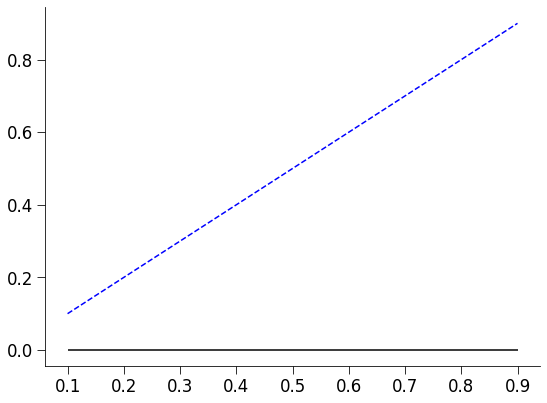

In [5]:
r1 = 1.
r0_range = np.arange(0.1, 1., 0.1)
dw_all = np.zeros(np.shape(r0_range))

for i,r0 in enumerate(r0_range):
    dw = hebbian_1synapse(r0, r1)
    dw_all[i] = dw

plt.plot(r0_range, dw_all, 'b--')
plt.hlines(0, r0_range[0], r0_range[-1], 'k', '-')
plt.show()

Hebbian with threshold 
dw = post (pre - threshold)

In [6]:
def hebbian_threshold_1synapse(r0, r1, theta):
    dw = r1 * (r0 - theta)
    return dw

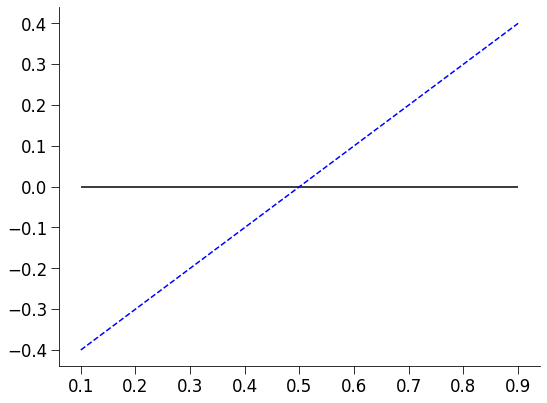

In [9]:
r1 = 1.
r0_range = np.arange(0.1, 1., 0.1)
dw_all = np.zeros(np.shape(r0_range))
theta = 0.5       # here we can put a slider for theta

for i,r0 in enumerate(r0_range):
    dw = hebbian_threshold_1synapse(r0, r1, theta)
    dw_all[i] = dw

plt.plot(r0_range, dw_all, 'b--')
plt.hlines(0, r0_range[0], r0_range[-1], 'k', '-')
plt.show()

BCM rule

In [12]:
def bcm_1synapse(r0, r1, theta):
    dw = r1 * (r1 - theta) * r0
    return dw

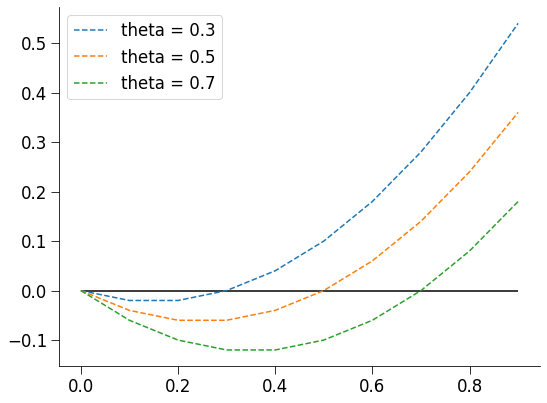

In [13]:
r0 = 1.
r1_range = np.arange(0.0, 1., 0.1)
dw_all = np.zeros(np.shape(r1_range))
#params['theta'] = 0.3

for theta in [0.3, 0.5, 0.7]:
    for i,r1 in enumerate(r1_range):
        dw = bcm_1synapse(r0, r1, theta)
        dw_all[i] = dw

    plt.plot(r1_range, dw_all, '--', label='theta = {}'.format(theta))

plt.hlines(0, r1_range[0], r1_range[-1], 'k', '-')
plt.legend()
plt.show()